# Booking and valuing a Forward Rate Agreement

In this notebook, we demonstrate how a Forward Rate Agreement (FRA) can be booked in LUSID, and extend it to use cases such as running a standard valuation and calculating PnL.

Information about FRAs can be found here: http://www.yieldcurve.com/Mktresearch/LearningCurve/FRAs.pdf

**Table of Contents:**
- [1. Create Portfolio](#1.-Create-Portfolio)
- [2. Create Instrument](#2.-Create-Instrument)
- [3. Upsert Transactions](#3.-Upsert-Transactions)
- [4. Upsert FX Market Data](#4.-Upsert-FX-Market-Data)
- [5. Create Configuration Recipe](#5.-Create-Configuration-Recipe)
- [6. Valuation](#6.-Valuation)
- [7. Instrument Lifecycle](#7.-Instrument-Lifecycle)

In [33]:
# Import generic non-LUSID packages
import os
import pandas as pd
from datetime import datetime, timedelta
import re
import matplotlib.pyplot as plt
%matplotlib inline
import json
import pytz
from IPython.core.display import HTML

# Import key modules from the LUSID package
import lusid
import lusid.models as lm
import lusid.api as la
from lusid.utilities import ApiClientFactory
from lusidtools.pandas_utils.lusid_pandas import lusid_response_to_data_frame

# Import key functions from Lusid-Python-Tools and other packages
from lusidjam import RefreshingToken

from utilities.instrument_utils import (
    add_utc_to_df,
    create_property,
)

# Set DataFrame display formats
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.options.display.float_format = "{:,.4f}".format
display(HTML("<style>.container { width:90% !important; }</style>"))

# Set the secrets path
secrets_path = os.getenv("FBN_SECRETS_PATH")

# For running the notebook locally
if secrets_path is None:
    secrets_path = os.path.join(os.path.dirname(os.getcwd()), "secrets.json")

# Authenticate our user and create our API client
api_factory = ApiClientFactory(
    token=RefreshingToken(),
    api_secrets_filename = secrets_path)

print ('LUSID Environment Initialised')
print ('LUSID API Version :', api_factory.build(lusid.api.ApplicationMetadataApi).get_lusid_versions().build_version)

LUSID Environment Initialised
LUSID API Version : 0.6.9848.0


In [34]:
# Set required APIs
portfolio_api = api_factory.build(lusid.api.PortfoliosApi)
transaction_portfolios_api = api_factory.build(lusid.api.TransactionPortfoliosApi)
instruments_api = api_factory.build(lusid.api.InstrumentsApi)
quotes_api = api_factory.build(lusid.api.QuotesApi)
configuration_recipe_api = api_factory.build(lusid.api.ConfigurationRecipeApi)
complex_market_data_api = api_factory.build(lusid.api.ComplexMarketDataApi)
aggregation_api = api_factory.build(lusid.api.AggregationApi)

In [35]:
# Define scopes
scope = "ibor"
market_data_scope = "ibor"
market_supplier = "Lusid"

# 1. Create Portfolio

We begin by creating a portfolio that will contain the FRA instrument that we will be looking to price.

In [36]:
portfolio_code = "fra"

try:
    transaction_portfolios_api.create_portfolio(
        scope=scope,
        create_transaction_portfolio_request=lm.CreateTransactionPortfolioRequest(
            display_name=portfolio_code,
            code=portfolio_code,
            base_currency="EUR",
            created="2010-01-01",
            sub_holding_keys=[],
            instrument_scopes=[scope]
        ),
    )

except lusid.ApiException as e:
    print(e.body)

{"name":"PortfolioWithIdAlreadyExists","errorDetails":[],"code":112,"type":"https://docs.lusid.com/#section/Error-Codes/112","title":"Could not create a portfolio with id 'fra' because it already exists in scope 'ibor'.","status":400,"detail":"Error creating portfolio with id 'fra' in scope 'ibor' effective at 2010-01-01T00:00:00.0000000+00:00 because it already exists.","instance":"https://andrewp.lusid.com/app/insights/logs/0HMK454M8AK55:00000004","extensions":{}}


# 2. Create Instrument

We create helper functions to create and upsert the FRA instrument into LUCID, this will reference the SDK models to populate the required parameters for creating a FRA. We then populate the instrument variables, and make a call to persist the instrument in LUSID.

In [37]:
# Define function that creates a FRA
def create_forward_rate_agreement(dom_ccy, start_date, maturity_date, fixing_date, fra_rate, index_convention):
    
    return lm.ForwardRateAgreement (
        instrument_type = "ForwardRateAgreement",
        dom_ccy = dom_ccy,
        start_date = start_date,
        maturity_date = maturity_date, 
        fixing_date = fixing_date, 
        fra_rate = fra_rate,
        notional = 1, #create unit instrument
        index_convention = index_convention
        )
    
# helper function to create the index convention
def create_index_convention (fixing_reference, day_lag, tenor, day_count_convention, ccy, index_name, scope, code):
    
    return lm.IndexConvention (
        fixing_reference=fixing_reference,
        publication_day_lag=day_lag,
        payment_tenor=tenor,
        day_count_convention=day_count_convention,
        currency=ccy,
        index_name=index_name,
        scope=scope,
        code=code,
    )

# Define a function to upsert instrument
def upsert_instrument_to_lusid(scope, instrument_definition, name, identifier, identifier_type):
        return instruments_api.upsert_instruments(
            request_body={
                identifier: lm.InstrumentDefinition(
                    name=name,
                    identifiers={
                        identifier_type: lm.InstrumentIdValue(value=identifier)
                    },
                    definition=instrument_definition,
                )
            },
            scope = scope
        )

## 2.1 Create Instrument


We are going to set up a 3 * 6 FRA. This would be used for the following scenario: A buyer of the FRA wants to hedge against a rise in interest rates for a 3 month loan, starting in 3 month's time. As such they transact a 3 against 6 FRA, also called a 3 * 6 or 3-v-6 FRA.

This results in two 3 month periods on the product with the start_date representing the start of the hedging period which occurs 3 months after the trade_date. The maturity_date is 3 months after the start_date, and it is this second period of 3 months where the interest rates are hedged.

In [38]:
# Setup trade variables
trade_date = datetime(2021, 1, 20, tzinfo=pytz.utc)
start_date = trade_date + timedelta(days = 90)  #3M after trade_date
maturity_date = start_date + timedelta(days = 90)  #3M after the start_date
fixing_days = 2
fixing_date = start_date - timedelta(days = fixing_days) #when there is a publication lag the fixing date occurs before the start_date of the FRA
notional = 1000000
instrument_ccy = "EUR"
identifier_type = "ClientInternal"
fra_rate = .33
payment_tenor= "3M"
reference_index = "LIBOR"
day_count_convention = "Actual360"
fra_name = "EUR.FRA.3M.LIBOR"
fra_identifier = "EURFRA3v6Demo"

# create the index convention
index_convention = create_index_convention (reference_index, fixing_days, payment_tenor, day_count_convention, instrument_ccy, reference_index, scope, portfolio_code)

# create the FRA instrument definition
fra_definition = create_forward_rate_agreement (instrument_ccy, start_date, maturity_date, fixing_date, fra_rate, index_convention)

# Upsert the instrument
upsert_response = upsert_instrument_to_lusid(scope, fra_definition, fra_name, fra_identifier, identifier_type)
luid = upsert_response.values[fra_identifier].lusid_instrument_id
print(f"{luid} : {fra_identifier}")

LUID_00003FW3 : EURFRA3v6Demo


# 3. Upsert Transactions

Having created the portfolio, we add a _StockIn_ transaction against the FRA to create a position without incurring any costs. Notice that this transaction type will simply increase our position by the given units, as opposed to a typical _Buy_/_Sell_, that would also impact cash.


In [39]:
# Book a StockIn transaction against the fra
fra_deal_id = "TXN001"
fra_version = 1

fra_txn = lm.TransactionRequest(
    transaction_id=fra_deal_id + "." + str(fra_version),
    type="StockIn",
    instrument_identifiers={"Instrument/default/ClientInternal": fra_identifier},
    transaction_date=trade_date,
    settlement_date=trade_date,
    units=notional,
    transaction_price=lm.TransactionPrice(price=0,type="Price"),
    total_consideration=lm.CurrencyAndAmount(amount=0,currency="EUR"),
    exchange_rate=1,
    transaction_currency="EUR"
)

response = transaction_portfolios_api.upsert_transactions(scope=scope,
                                                    code=portfolio_code,
                                                    transaction_request=[fra_txn])

print(f"Transaction successfully updated at time: {response.version.as_at_date}")
fra_version + 1


Transaction successfully updated at time: 2022-08-22 10:31:16.587023+00:00


2

# 4. Upsert Market Data

Next we will be loading the required marked data into the quotes store. In this particular example, we will require the following data:
1. EUR discount curve
2. LIBOR 3M fixing values

## 4.1 EUR Discount curves

We will read in the EUR Discount factors and create a EUR discount curve from this example data.

In [40]:
# Read FX market data - showing first 10 terms
df_market_data = pd.read_csv("data/EURUSD-MarketData.csv")
df_market_data["Days"]= df_market_data["Days"].astype(int)

# remove volatility data from the dataframe as this is not used in this example notebook
df_market_data = df_market_data.drop(columns=["Vol25D", "ATM", "Vol75D", "Strike25D", "StrikeATM", "Strike75D"])
df_market_data = df_market_data.reset_index()
df_market_data.head(10)

,index,Tenor,Days,EUR-Rates,USD-Rates,EURdf,USDdf
0,0,1M,30,0.2200,1.2200,0.9998,0.9990
1,1,2M,60,0.3700,1.3700,0.9994,0.9978
2,2,3M,90,0.5300,1.5300,0.9987,0.9962
3,3,6M,180,0.9500,1.9500,0.9953,0.9904
4,4,1Y,365,1.3000,2.3000,0.9871,0.9773
5,5,18M,547,1.5000,2.5000,0.9778,0.9632
6,6,2Y,730,1.5000,2.5000,0.9705,0.9513
7,7,3Y,1095,1.4300,2.4300,0.9580,0.9297
8,8,4Y,1460,1.3700,2.3700,0.9467,0.9096
9,9,5Y,1825,1.3100,2.3100,0.9366,0.8909


In [41]:
# Set up the OIS curves loader function
def upsert_discount_factors(scope, effective_at, market_asset, dates, dfs):

    complex_market_data = lm.DiscountFactorCurveData(
        base_date=effective_at,
        dates=dates,
        discount_factors = dfs,
        market_data_type="DiscountFactorCurveData"
    )

    # create a unique identifier for our OIS yield curves
    complex_id = lm.ComplexMarketDataId(
        provider=market_supplier,
        price_source = market_supplier,
        effective_at=effective_at,
        market_asset=market_asset,
    )
    
    upsert_request = lm.UpsertComplexMarketDataRequest(
        market_data_id=complex_id, market_data=complex_market_data
    )


    response = complex_market_data_api.upsert_complex_market_data(
        scope=scope, request_body={market_asset: upsert_request}
    )
    
    if response.failed:
        print(f"Failed to upload yield curve {response.failed}")

    print(f"{market_asset} yield curve uploaded into scope={scope}")
    
    return complex_id

In [42]:
# To create the OIS curve, we will use the EURdf from the spreadsheet
base_date = trade_date
dates = []
dfs = []

for index, row in df_market_data.iterrows():
    dates.append(base_date + timedelta(days=row["Days"]))
    dfs.append(row["EURdf"])

curve_id_EUR_OIS = upsert_discount_factors(market_data_scope, base_date, f"EUR/EUROIS", dates, dfs)

EUR/EUROIS yield curve uploaded into scope=ibor


In [43]:
# To create the LIBOR curve, will use the EURdf from the spreadsheet with an additional spread of 0.01
base_date = trade_date
dates = []
dfs = []

for index, row in df_market_data.iterrows():
    dates.append(base_date + timedelta(days=row["Days"]))
    dfs.append(row["EURdf"] + 0.01)

curve_id_EUR_LIBOR = upsert_discount_factors(market_data_scope, base_date, f"EUR/{payment_tenor}/LIBOR", dates, dfs)

EUR/3M/LIBOR yield curve uploaded into scope=ibor


We can also use the _ComplexMarketDataApi_ to retrieve the data as it's been stored in LUSID. See below for the returned object, and a plot showing both the OIS and LIBOR curves.

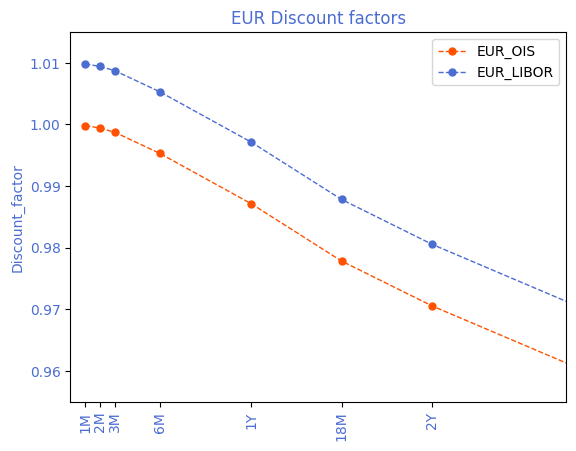

In [44]:
# Retrieve each curve
EUR_OIS_curve = complex_market_data_api.get_complex_market_data(
    scope=market_data_scope,
    request_body= {"1": curve_id_EUR_OIS}
)

EUR_LIBOR_curve = complex_market_data_api.get_complex_market_data(
    scope=market_data_scope,
    request_body= {"1": curve_id_EUR_LIBOR}
)

# Get axis data and create plot
plt.plot(df_market_data["Days"],EUR_OIS_curve.values["1"].discount_factors, color='#ff5200' , marker='o', markersize=5, linestyle='--', linewidth=1, label="EUR_OIS")
plt.plot(df_market_data["Days"],EUR_LIBOR_curve.values["1"].discount_factors, color='#4b6dd1' , marker='o', markersize=5, linestyle='--', linewidth=1, label="EUR_LIBOR")
plt.yticks(color = '#4b6dd1')
plt.xticks(df_market_data["Days"], df_market_data["Tenor"], rotation='vertical', color = '#4b6dd1')
plt.title('EUR Discount factors', color = '#4b6dd1')
plt.ylabel('Discount_factor', color = '#4b6dd1')
plt.xlim([0, 1000]), plt.ylim([.955, 1.015])
plt.legend(loc="upper right")
plt.show()

## 4.2 LIBOR 3M Rates

Next we will read in the LIBOR fixing data, this data is representing the daily LIBOR 3M fixings.

In [45]:
# Read fixings for LIBOR
resets_df = pd.read_csv("data/LIBOR-rates.csv")
resets_df["Date"] = pd.to_datetime(resets_df["Date"],dayfirst=True)
add_utc_to_df(resets_df)
resets_df.head()

,Date,Rate,Index
0,2021-01-03 00:00:00+00:00,1.2025,LIBOR
1,2021-01-04 00:00:00+00:00,1.2050,LIBOR
2,2021-01-05 00:00:00+00:00,1.2062,LIBOR
3,2021-01-06 00:00:00+00:00,1.2038,LIBOR
4,2021-01-07 00:00:00+00:00,1.2011,LIBOR


In [46]:
# Create quotes request
instrument_quotes = {
            index: lm.UpsertQuoteRequest(
            quote_id=lm.QuoteId(
                quote_series_id=lm.QuoteSeriesId(
                    provider="Lusid",
                    instrument_id="LIBOR",
                    instrument_id_type="RIC",
                    quote_type="Rate",
                    field="mid",
                ),
                effective_at=row["Date"],
            ),
            metric_value=lm.MetricValue(value=row["Rate"], unit="rate"),
            scale_factor=100
        )
    for index, row in resets_df.iterrows()
}

# Upsert quotes into LUSID
response = quotes_api.upsert_quotes(
    scope=market_data_scope, request_body=instrument_quotes
)


if response.failed == {}:
    print(f"Quotes successfully loaded into LUSID. {len(response.values)} quotes loaded.")
else:
    print(f"Some failures occurred during quotes upsertion, {len(response.failed)} did not get loaded into LUSID.")

Quotes successfully loaded into LUSID. 118 quotes loaded.


# 5. Create Configuration Recipe

In order to run a valuation, LUSID will require a recipe that drives how a valuation will be conducted. The below recipe defines what model and market data to use in this context.


In [47]:
# Set recipe code
recipe_code = "FraValuation"

# Populate recipe parameters
configuration_recipe = lm.ConfigurationRecipe(
    scope=market_data_scope,
    code=recipe_code,
    market=lm.MarketContext(
        market_rules=[
            lm.MarketDataKeyRule(
                key="Quote.RIC.*", # Ties back to LIBOR fixings
                supplier="Lusid",
                data_scope=market_data_scope,
                quote_type="Rate",
                field="mid",
                quote_interval="90D",
            ),
            lm.MarketDataKeyRule(
                key="Rates.*.*",
                supplier=market_supplier,
                data_scope=market_data_scope,
                price_source=market_supplier,
                quote_type="Price",
                field="mid",
                quote_interval="100D",
            ),
            lm.MarketDataKeyRule(
                key="Rates.*.*.*",
                supplier=market_supplier,
                data_scope=market_data_scope,
                price_source=market_supplier,
                quote_type="Price",
                field="mid",
                quote_interval="100D",
            ),
        ],
    ),
    pricing=lm.PricingContext(
        model_rules=[
            lm.VendorModelRule(
                supplier="Lusid",
                model_name="Discounting",
                instrument_type="ForwardRateAgreement",
                parameters="{}",
            )
        ],
    ),
)

response = configuration_recipe_api.upsert_configuration_recipe(
    upsert_recipe_request=lm.UpsertRecipeRequest(
        configuration_recipe=configuration_recipe
    )
)


print(f"Configuration recipe loaded into LUSID at time {response.value}.")

Configuration recipe loaded into LUSID at time 2022-08-22 10:31:18.964381+00:00.


# 6. Valuation

Value the trade using the Discounting model on the trade date

In [48]:
def run_valuation(date, portfolio_code):

    metrics = [
        lm.AggregateSpec("Instrument/default/Name", "Value"),
        lm.AggregateSpec("Instrument/default/ClientInternal", "Value"),
        lm.AggregateSpec("Holding/default/Units", "Value"),
        lm.AggregateSpec("Valuation/PV/Amount", "Value"),
        lm.AggregateSpec("Valuation/PvInPortfolioCcy", "Value"),
        lm.AggregateSpec("Valuation/Accrued", "Value"),
    ]

    group_by =[]

    valuation_request = lm.ValuationRequest(
        recipe_id=lm.ResourceId(scope=market_data_scope, code=recipe_code),
        metrics=metrics,
        group_by=group_by,
        portfolio_entity_ids=[
            lm.PortfolioEntityId(scope=scope, code=portfolio_code)
        ],
        valuation_schedule=lm.ValuationSchedule(effective_at=date),
    )

    val_data = aggregation_api.get_valuation(valuation_request=valuation_request).data
    
    vals_df = pd.DataFrame(val_data)
    

    vals_df.rename(
        columns={
            "Instrument/default/Name": "InstrumentName",
            "Instrument/default/ClientInternal": "ClientInternal",
            "Valuation/PvInPortfolioCcy": "Market Value",
            "Valuation/Diagnostics/FxForwardRate": "Forward Rate (Interpolated)",
            "Quotes/FxRate/DomFgn": "FX Spot Rate",
            "Valuation/PnL/Tm1/Pfolio": "PnL (1-day)"
        },
        inplace=True,
    )

    return vals_df

In [49]:
valuation = run_valuation(trade_date, portfolio_code)
display(valuation)

,Valuation/PV/Amount,InstrumentName,ClientInternal,Holding/default/Units,Market Value,Valuation/Accrued
0,"79,336.0792",EUR.FRA.3M.LIBOR,EURFRA3v6Demo,"1,000,000.0000","79,336.0792",0.0000


## 6.1 Valuation over time

Running the valuation over the lifetime of the FRA to show the impact of the cashflow being generated on the fixing date. The output below shows the PVs at different valuation dates.

In [50]:
dates = []
pvs = []

for i in range (0, 7):
    valuation_date = trade_date + timedelta (days=14 * i)
    valuation = run_valuation(valuation_date, portfolio_code)
    dates.append(valuation_date)
    
    # depending on where the portfolio is lifecycled to, we need to cater for 0 valuations here
    if valuation.empty:
        pvs.append(0.0)
    else:
        pvs.append(valuation ["Market Value"].sum())

valuation_over_time = pd.DataFrame({"Date" : dates, "PV" : pvs})
valuation_over_time

,Date,PV
0,2021-01-20 00:00:00+00:00,"79,336.0792"
1,2021-02-03 00:00:00+00:00,"79,343.4850"
2,2021-02-17 00:00:00+00:00,"79,350.8915"
3,2021-03-03 00:00:00+00:00,"79,364.6520"
4,2021-03-17 00:00:00+00:00,"79,379.4740"
5,2021-03-31 00:00:00+00:00,"79,402.2521"
6,2021-04-14 00:00:00+00:00,"79,428.2190"


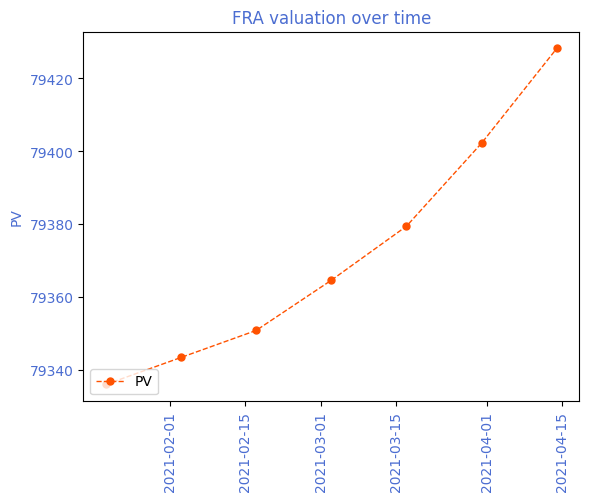

In [51]:
# Get axis data and create plot
plt.plot(valuation_over_time["Date"],valuation_over_time["PV"], color='#ff5200' , marker='o', markersize=5, linestyle='--', linewidth=1, label="PV")

plt.xticks( color = '#4b6dd1', rotation='vertical')
plt.yticks( color = '#4b6dd1')
plt.title('FRA valuation over time', color = '#4b6dd1')
plt.ylabel('PV', color = '#4b6dd1')
plt.legend(loc="lower left")
plt.show()

# 7. Instrument Lifecycle

At the start date we would expect the trade to generate a cashflow equal to the interest earned over the FRA period, according to the difference between the FRA rate and the reference index (in this case LIBOR 3M). The cashflow is paid on the start_date of the FRA.

In [52]:
# first lets get the valuation of the portfolio on the day before the start_date
valuation = run_valuation(start_date + timedelta(days=-1), portfolio_code)
display(valuation)

,Valuation/PV/Amount,InstrumentName,ClientInternal,Holding/default/Units,Market Value,Valuation/Accrued
0,"79,437.4950",EUR.FRA.3M.LIBOR,EURFRA3v6Demo,"1,000,000.0000","79,437.4950",0.0000


In [53]:
# get the cash flows
fra_cash_flows = transaction_portfolios_api.get_upsertable_portfolio_cash_flows(
    scope=scope,
    code=portfolio_code,
    effective_at=trade_date,
    window_start=trade_date,
    window_end=start_date,
    recipe_id_scope=scope,
    recipe_id_code=recipe_code
)

# we create a dataframe out of the cash flows table
cash_flow_table = lusid_response_to_data_frame(fra_cash_flows)
cash_flow_table

,transaction_id,type,instrument_identifiers.Instrument/default/LusidInstrumentId,instrument_scope,instrument_uid,transaction_date,settlement_date,units,transaction_price.price,transaction_price.type,total_consideration.amount,total_consideration.currency,exchange_rate,transaction_currency,properties,source,entry_date_time,transaction_status
0,TXN001.1-LUID_00003FW3-20210420-Cash-EUR-Receive,CashFlow,LUID_00003FW3,ibor,LUID_00003FW3,2021-04-20 00:00:00+00:00,2021-04-20 00:00:00+00:00,"79,714.2842",1.0000,Price,"79,714.2842",EUR,1.0000,EUR,{},default,0001-01-01 00:00:00+00:00,Active


## Cash generation process

On the start date the cashflows are know, and the FRA simply needs to pay out the net cashflow. We will therefore do 2 things:
1. Book the resulting cashflow in the system
2. Set the FRA position to 0

In [54]:
# Book the cash flow as a cash transactions
non_zero_upsertable_cash_flows = []

for x in fra_cash_flows.values:
    if x.units != 0:
        non_zero_upsertable_cash_flows.append(x)

if len(non_zero_upsertable_cash_flows) > 0:
    # Upsert the cash transactions
    response = transaction_portfolios_api.upsert_transactions(
        scope=scope,
        code=portfolio_code,
        transaction_request=non_zero_upsertable_cash_flows
    )
    print(f"Cashflows successfully updated at time: {response.version.as_at_date}")
else:
    print(f"No cashflows to upload")

Cashflows successfully updated at time: 2022-08-22 08:19:35.730587+00:00


In [55]:
# Now book a StockOut to remove the FRA position
fra_txn = lm.TransactionRequest(
    transaction_id=fra_deal_id + "." + str(fra_version),
    type="StockOut",
    instrument_identifiers={"Instrument/default/ClientInternal": fra_identifier},
    transaction_date=fixing_date,
    settlement_date=fixing_date,
    units=notional,
    transaction_price=lm.TransactionPrice(price=0,type="Price"),
    total_consideration=lm.CurrencyAndAmount(amount=0,currency="EUR"),
    exchange_rate=1,
    transaction_currency="EUR"
)

response = transaction_portfolios_api.upsert_transactions(scope=scope,
                                                    code=portfolio_code,
                                                    transaction_request=[fra_txn])

print(f"Transaction successfully updated at time: {response.version.as_at_date}")
fra_version +1


Transaction successfully updated at time: 2022-08-22 10:31:30.474661+00:00


2

In [56]:
# To check that the portfolio values correctly after these transactions
valuation = run_valuation(start_date + timedelta(days=0), portfolio_code)
display(valuation)

,Valuation/PV/Amount,InstrumentName,ClientInternal,Holding/default/Units,Market Value,Valuation/Accrued
0,0.0000,EUR.FRA.3M.LIBOR,EURFRA3v6Demo,"-1,000,000.0000",0.0000,0.0000
1,"79,714.2842",EUR,None,"79,714.2842","79,714.2842",0.0000


# 8.A2B Report for P&L
Next we are going to run a LUSID A2B report on the portfolio, which will break down the P&L of the position for a given window.

The AtoB report will give a breakdown of each holding's P&L, including the flows (transactions) that have occurred in the selected window. Within the report you will find the following detail:

Market Value (Start): The market value at the start of the window.
Market Gain: Capital Gain, or gain due to asset appreciation based on available market data.
Carry: Interest and dividend accruals where applicable, also known as carry return.
Flows: Any transaction activity occurring in the period (buys, sells, etc.).
Market Value (End): The market value of the security at the end of the window.

In [57]:
# Request A2B report
a2b = transaction_portfolios_api.get_a2_b_data(
    scope=scope,
    code=portfolio_code,
    from_effective_at=trade_date,
    to_effective_at=start_date + timedelta(days=3),
    recipe_id_scope=market_data_scope,
    recipe_id_code=recipe_code,
    property_keys=["Instrument/default/Name"]
)

,Portfolio Scope,Portfolio Code,Holding Type,Instrument ID,Instrument Name,Market Value (End)
0,ibor,fra,B,CCY_EUR,EUR,"79,714.2800"
1,ibor,fra,P,LUID_00003FW3,EUR.FRA.3M.LIBOR,0.0000


In [70]:
# Rename A2B columns in df
rename_cols = {
    "portfolio_id.scope": "Portfolio Scope",
    "portfolio_id.code": "Portfolio Code",
    "holding_type": "Holding Type",
    "instrument_uid": "Instrument ID",
    "Name(default-Properties)": "Instrument Name",
    "carry.portfolio_currency.total": "Carry (Window)",
    "end.portfolio_currency.total": "Market Value (End)"
}

# Format and filter A2B
a2b_df = lusid_response_to_data_frame(a2b, rename_properties=True)
a2b_df = a2b_df.drop(columns=["carry.portfolio_currency.total"])

#the renaming of the columns can fail depending on the results returned from the portfolio
try:
    col_filters = rename_cols.keys()
    a2b_df = a2b_df[col_filters].copy()
    a2b_df.rename(columns=rename_cols, inplace=True)
except Exception as e:
    print(f"Can not rename columns {e}")

a2b_df

Can not rename columns "['carry.portfolio_currency.total'] not in index"


,portfolio_id.scope,portfolio_id.code,holding_type,instrument_scope,instrument_uid,sub_holding_keys,currency,flows.holding_currency.total,flows.holding_currency.currency,flows.holding_currency.components.In,flows.portfolio_currency.total,flows.portfolio_currency.currency,flows.portfolio_currency.components.In,end.holding_currency.total,end.holding_currency.currency,end.holding_currency.components.Cost,end.portfolio_currency.total,end.portfolio_currency.currency,end.portfolio_currency.components.Cost,Name(default-Properties),group_id,errors,flows.holding_currency.components.CarryCashFlow,flows.portfolio_currency.components.CarryCashFlow,carry.holding_currency.total,carry.holding_currency.currency,carry.holding_currency.components.CarryCashFlow,carry.portfolio_currency.currency,carry.portfolio_currency.components.CarryCashFlow,end.holding_currency.components,end.portfolio_currency.components
0,ibor,fra,B,default,CCY_EUR,{},EUR,"79,714.2800",EUR,"79,714.2800","79,714.2800",EUR,"79,714.2800","79,714.2800",EUR,"79,714.2800","79,714.2800",EUR,"79,714.2800",EUR,Currency=EUR.Scope:ibor Code:fra,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ibor,fra,P,ibor,LUID_00003FW3,{},EUR,"-79,714.2800",EUR,NaN,"-79,714.2800",EUR,NaN,0.0000,EUR,NaN,0.0000,EUR,NaN,EUR.FRA.3M.LIBOR,LusidInstrumentId=LUID_00003FW3/EUR.Scope:ibor...,[],"-79,714.2800","-79,714.2800","79,714.2800",EUR,"79,714.2800",EUR,"79,714.2800",{},{}
